In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load the dataset using input. For example use "C:/Users/Jose Guevara/Desktop/Kaggle/Binary Classification of Insurance Cross Selling/train.csv"
"C:/Users/Jose Guevara/Desktop/Kaggle/Binary Classification of Insurance Cross Selling/train.csv"
file_path = input("Please enter the path to the CSV file: ")
df = pd.read_csv(file_path)

In [10]:
# Overview of the data
print("Data Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe(include='all'))

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None

Summary Statistics:
                   id  Gender            Age  Driving_Lic

In [11]:
# Convert 'Vehicle_Age', 'Vehicle_Damage', and 'Gender' to categorical
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Set 'id' as index
df.set_index('id', inplace=True)

In [12]:
# Define features and target variable
X = df.drop(columns='Response')
y = df['Response']

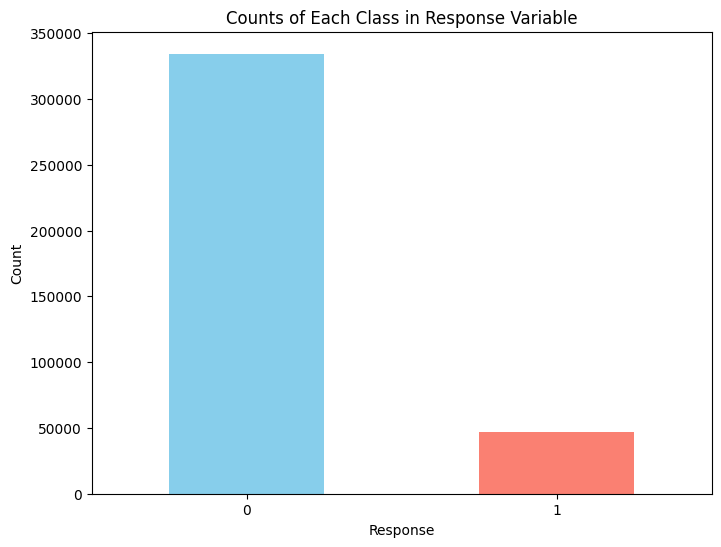

In [13]:
# Plot the counts for each class of the Response variable
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Counts of Each Class in Response Variable')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the model
# Initialize the model with class weights
lgbm = lgb.LGBMClassifier(class_weight='balanced')

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'objective': ['binary'],
    'boosting_type': ['gbdt'],
    'metric': ['binary_logloss'],
    'feature_fraction': [0.7, 0.8, 0.9],
    #'subsample': [0.7, 0.8, 0.9]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_lgbm = grid_search.best_estimator_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [16]:
# Make predictions
y_pred = best_lgbm.predict(X_test)
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1]

In [17]:
# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

In [18]:
print("\nClassification Report:")
print(classification_rep)
print("AUC ROC Score:", auc_roc)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     66880
           1       0.29      0.86      0.44      9342

    accuracy                           0.73     76222
   macro avg       0.63      0.78      0.63     76222
weighted avg       0.89      0.73      0.77     76222

AUC ROC Score: 0.8430736575520953


[[47368 19512]
 [ 1305  8037]]


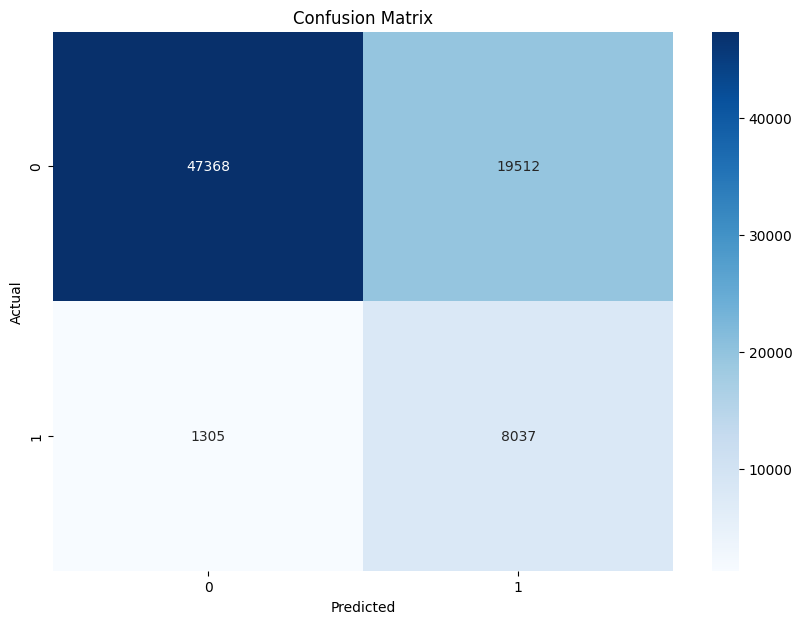

In [19]:
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

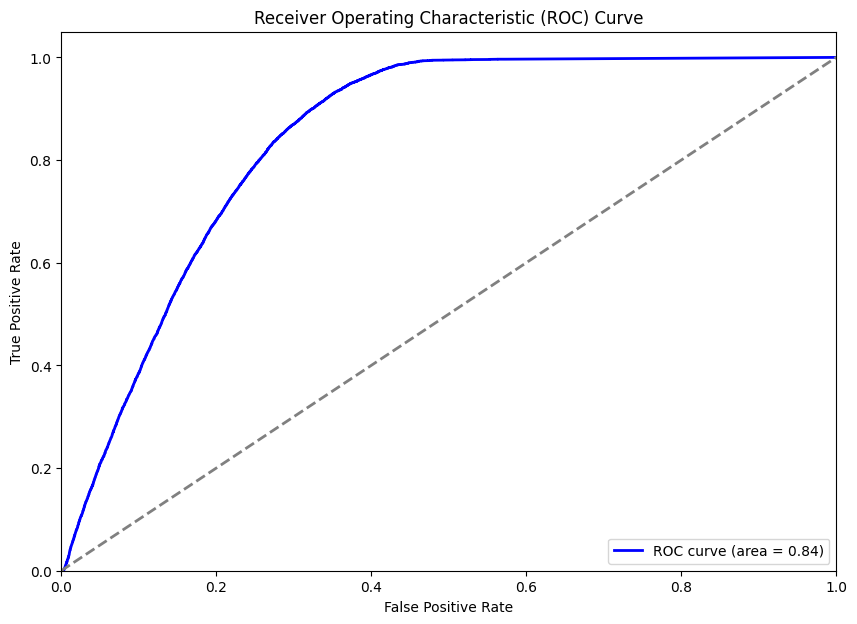

AUC ROC Score: 0.84


In [20]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print("AUC ROC Score:", auc_roc.round(2))

In [21]:
# SHAP feature importance
explainer = shap.Explainer(best_lgbm, X_train)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 76208/76222 [13:59<00:00]        

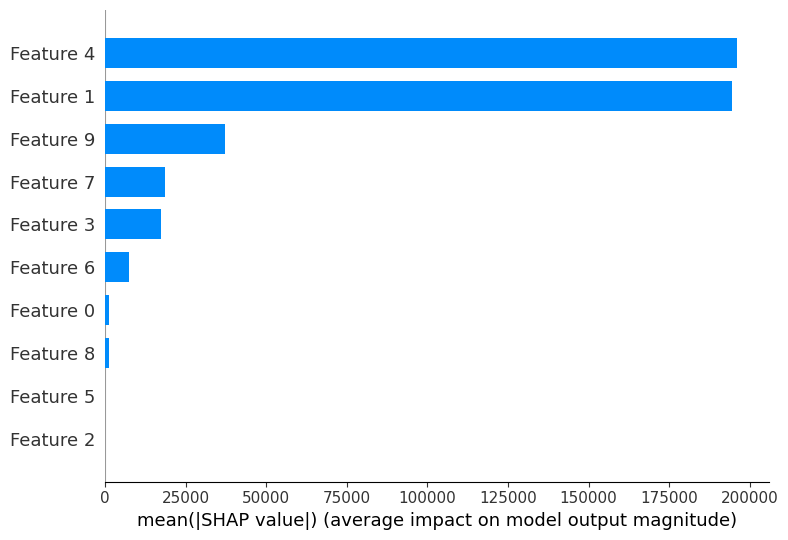

In [22]:
# Plot feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

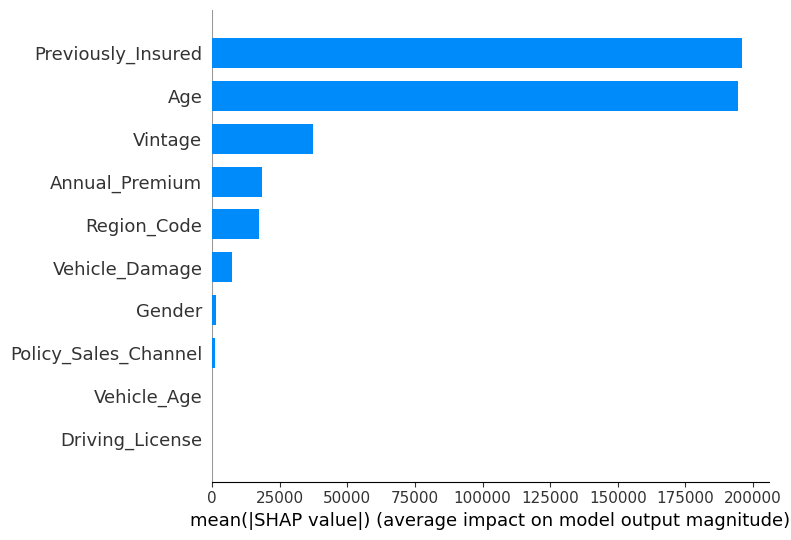

In [25]:
# Plot feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), plot_type="bar")
plt.show()

In [28]:
# Load the test set
test_file_path = "C:/Users/Jose Guevara/Desktop/Kaggle/Binary Classification of Insurance Cross Selling/test.csv"
test_df = pd.read_csv(test_file_path)

In [29]:
# Process the test set in the same way as the training set
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
test_df['Gender'] = test_df['Gender'].map({'Male': 1, 'Female': 0})

# Set 'id' as index
test_df.set_index('id', inplace=True)

In [30]:
# Define features
X_final_test = test_df

# Standardize the data
X_final_test = scaler.transform(X_final_test)

In [33]:
# Predict the Response and Probabilities for the test set
final_test_pred_proba = best_lgbm.predict_proba(X_final_test)
final_test_predictions = np.argmax(final_test_pred_proba, axis=1)

# Create a DataFrame to store the results
results_df = test_df.copy()
results_df['Predicted_Response'] = final_test_predictions
results_df['Prediction_Probability_Class_0'] = final_test_pred_proba[:, 0]
results_df['Prediction_Probability_Class_1'] = final_test_pred_proba[:, 1]

In [34]:
# Save the results to a CSV file
results_df.to_csv("C:/Users/Jose Guevara/Desktop/Kaggle/Binary Classification of Insurance Cross Selling/final_test_predictions_w_probs.csv")

print("Predictions and probabilities have been saved to final_test_predictions.csv")

Predictions and probabilities have been saved to final_test_predictions.csv
